# Past and future response of the North Atlantic warming hole to anthropogenic forcings

This notebook provides code for applying the KCC constrain and generating the key figures from the paper by Qasmi (submitted). 

## 1. Introduction

As **input**, I use pre-processed CMIP6 model outputs: 
- Xg: GSAT annual mean temperature. An array [year,experiment,model].
- Xa: Annual mean SST average over the warming hole. Pre-processing in this case includes computation of the spatial average, then the annual mean SST. An array [year,experiment,model].
Inputs also include observed data:
- Xog: HadCRUT5 observations of GSAT, an [year,enc_member] array,
- Xof: HadSST4 annual SST over the WH, an [year] array.

As **output**, I provide:
- Xg_fit: the estimated forced GSAT responses. An array [year,forcing,model]. Forcing is one of "all","nat","ghg", given other terms (e.g., "ant","oa") can be recovered assuming additivity.
- Xa_fit: same for the regional temperature.
- Array CX_full (defined later), and also generate the key figures of the paper.

Note that inputs (e.g., Xg) include the data for various SSP scenarios (1-1.9, 2-4.5, 5-8.5), but the estimation of forced responses is made for "histssp245" only in this notebook. Replication to other scenarios is easy.

## 2. Get started 

Some preliminary R commands

In [1]:
rm(list=ls())
library(KCC)
library(gam)
library(abind)
library(MASS)
# Set random number generator to ensure reproducibility
set.seed(13)

Loading required package: splines

Loading required package: foreach

Loaded gam 1.20




As the estimation of the ANT response involves smoothing splines, we need to select the number of equivalent degrees of freedom.

In [2]:
experiments = c("histssp126", "histssp245", "histssp585", "1pctCO2", "hist-GHG")
nexp = length(experiments)

# The effective df in x_fit (ANT component)
dfg = c( 6, 6, 6, 5, 6 )
names(dfg) = experiments
dfa = c( 8, 8, 8, 6, 7 )
names(dfa) = experiments

Load input data (Xg, Xf)

In [3]:
Xg = loadRData("./data/GSAT_CMIP6_ann_idx.Rdata")
year_g = as.numeric(dimnames(Xg)$year)
Models_g = dimnames(Xg)$model
ny_g = length(year_g)
Nmod_g = length(Models_g)

#Xa = loadRData("./data/tos-SPNA_CMIP6_simulations_idx.Rdata")
Xa = loadRData("./data/tos-SPNA-fixed_CMIP6_simulations_idx.Rdata")
year_a = as.numeric(dimnames(Xa)$year)
Models_a_tmp = dimnames(Xa)$model
Models_a = Models_a_tmp[Xa["1850","histssp245",,"nb_members"] >= 1 ]
ny_a = length(year_a)
Nmod_a = length(Models_a)

scenarios = c("histssp126", "histssp245", "histssp585")
Nsim = length(scenarios)

Initialize outputs: Xg_fit, Xa_fit

In [4]:
Xg_fit = array(NA,dim=c(ny_g,Nsim,3,Nmod_g),#
               dimnames=list(year = as.character(year_g),#
                             scenario = scenarios,
                             forc = c("all","nat","ghg"),#
                             model = Models_g))
Xa_fit = array(NA,dim=c(ny_a,Nsim,3,Nmod_a),#
               dimnames=list(year = as.character(year_a),#
                             scenario = scenarios,
                             forc = c("all","nat","ghg"),#
                             model = Models_a))

## 3. Estimating ALL and NAT responses

We first derive an simple EBM response to the CMIP6 NAT forcings time-series.

In [5]:
load("./data/FF_CMIP6_new.rda")
load("./data/ebm_params.rda")
Enat = ebm_response(FF,ebm_params,year_g,Nres=1)

ALL and NAT responses in GSAT (i.e., Xg --> Xg_fit).

In [6]:
message("Global T: Xg_fit")

# General case
Models_scen_full_g = Models_g[ apply(is.na(Xg[,"histssp245",,"value"]),2,sum)==0 ]

for (iscen in scenarios) {
   Xg_fit[,iscen,c("all","nat"),Models_scen_full_g] = x_fit(Xg[,iscen,Models_scen_full_g,"value"],Enat,dfg[iscen],ant=F) 
}

# Particular cases
# CAMS-CSM1-0 (simulation stops in 2099)
year_cams = as.character(1850:2099)
for (iscen in scenarios) {
    Xg_fit[year_cams,iscen,c("all","nat"),"CAMS-CSM1-0"] = x_fit( Xg[year_cams,iscen,c("CAMS-CSM1-0","CAMS-CSM1-0"),"value"], Enat[year_cams,],dfg[iscen],ant=F)[,,1]
    Xg_fit["2100",iscen,,"CAMS-CSM1-0"] = 2 * Xg_fit["2099",iscen,,"CAMS-CSM1-0"] - Xg_fit["2098",iscen,,"CAMS-CSM1-0"]
}



Global T: Xg_fit

		ACCESS-CM2

		ACCESS-ESM1-5

		AWI-CM-1-1-MR

		BCC-CSM2-MR

		CanESM5-CanOE

		CanESM5

		CESM2

		CESM2-WACCM

		CIESM

		CMCC-CM2-SR5

		CNRM-CM6-1

		CNRM-CM6-1-HR

		CNRM-ESM2-1

		EC-Earth3

		EC-Earth3-Veg

		FGOALS-f3-L

		FGOALS-g3

		FIO-ESM-2-0

		GFDL-ESM4

		GISS-E2-1-G

		HadGEM3-GC31-LL

		INM-CM4-8

		IPSL-CM6A-LR

		KACE-1-0-G

		KIOST-ESM

		MCM-UA-1-0

		MIROC6

		MIROC-ES2L

		MPI-ESM1-2-HR

		MPI-ESM1-2-LR

		MRI-ESM2-0

		NESM3

		NorESM2-LM

		NorESM2-MM

		TaiESM1

		UKESM1-0-LL

		ACCESS-CM2

		ACCESS-ESM1-5

		AWI-CM-1-1-MR

		BCC-CSM2-MR

		CanESM5-CanOE

		CanESM5

		CESM2

		CESM2-WACCM

		CIESM

		CMCC-CM2-SR5

		CNRM-CM6-1

		CNRM-CM6-1-HR

		CNRM-ESM2-1

		EC-Earth3

		EC-Earth3-Veg

		FGOALS-f3-L

		FGOALS-g3

		FIO-ESM-2-0

		GFDL-ESM4

		GISS-E2-1-G

		HadGEM3-GC31-LL

		INM-CM4-8

		IPSL-CM6A-LR

		KACE-1-0-G

		KIOST-ESM

		MCM-UA-1-0

		MIROC6

		MIROC-ES2L

		MPI-ESM1-2-HR

		MPI-ESM1-2-LR

		MRI-ESM2-0

		NESM3

		NorESM2-LM



Same thing for the SST Xa

In [7]:
message("WH SST: Xa_fit")
# General case
Models_scen_full_a = Models_a[ apply(is.na(Xa[,"histssp245",Models_a,"value"]),2,sum)==0]

for (iscen in scenarios) {
    Xa_fit[,iscen,c("all","nat"),Models_scen_full_a] = x_fit(Xa[,iscen,Models_scen_full_a,"value"],Enat,dfa[iscen],ant=F)
}

# Particular cases
# CAMS-CSM1-0 (simulation stops in 2099)
year_cams = as.character(1850:2099)
for (iscen in scenarios) {
    Xa_fit[year_cams,iscen,c("all","nat"),"CAMS-CSM1-0"] = x_fit(Xa[year_cams,iscen,c("CAMS-CSM1-0","CAMS-CSM1-0"),"value"], Enat[year_cams,],dfa[iscen],ant=F)[,,1]
    Xa_fit["2100",iscen,,"CAMS-CSM1-0"] = 2 * Xa_fit["2099",iscen,,"CAMS-CSM1-0"] - Xa_fit["2098",iscen,,"CAMS-CSM1-0"]
}


WH SST: Xa_fit

		ACCESS-CM2

		ACCESS-ESM1-5

		BCC-CSM2-MR

		CanESM5-CanOE

		CanESM5

		CESM2

		CESM2-WACCM

		CNRM-CM6-1

		CNRM-CM6-1-HR

		CNRM-ESM2-1

		EC-Earth3

		EC-Earth3-Veg

		FGOALS-f3-L

		FGOALS-g3

		FIO-ESM-2-0

		HadGEM3-GC31-LL

		INM-CM4-8

		INM-CM5-0

		IPSL-CM6A-LR

		MIROC6

		MIROC-ES2L

		MPI-ESM1-2-HR

		MPI-ESM1-2-LR

		MRI-ESM2-0

		NorESM2-LM

		NorESM2-MM

		UKESM1-0-LL

		ACCESS-CM2

		ACCESS-ESM1-5

		BCC-CSM2-MR

		CanESM5-CanOE

		CanESM5

		CESM2

		CESM2-WACCM

		CNRM-CM6-1

		CNRM-CM6-1-HR

		CNRM-ESM2-1

		EC-Earth3

		EC-Earth3-Veg

		FGOALS-f3-L

		FGOALS-g3

		FIO-ESM-2-0

		HadGEM3-GC31-LL

		INM-CM4-8

		INM-CM5-0

		IPSL-CM6A-LR

		MIROC6

		MIROC-ES2L

		MPI-ESM1-2-HR

		MPI-ESM1-2-LR

		MRI-ESM2-0

		NorESM2-LM

		NorESM2-MM

		UKESM1-0-LL

		ACCESS-CM2

		ACCESS-ESM1-5

		BCC-CSM2-MR

		CanESM5-CanOE

		CanESM5

		CESM2

		CESM2-WACCM

		CNRM-CM6-1

		CNRM-CM6-1-HR

		CNRM-ESM2-1

		EC-Earth3

		EC-Earth3-Veg

		FGOALS-f3-L

		FGOALS-

## 4. Estimating GHG response for the CMIP6 models not involved in DAMIP

This is the most difficult step. The strategy is as follows (see details in Ribes et al., 2021, https://www.science.org/doi/10.1126/sciadv.abc0671):
- a. Some CMIP6 models have contributed to DAMIP and provided (complete) hist-ghg runs. For these models, we estimate the GHG response by smoothing the GSAT and WH SST from hist-ghg runs.
- b. Many CMIP6 models simply did not contribute to DAMIP (meaning no hist-ghg run available). For these, we reconstruct the missing hist-ghg runs from the 1%CO2 experiment, and using the ensemble of DAMIP models as a learning sample (i.e. to learn the relationship between the histghg response and the 1%CO2 response). 

With start with a.

In [8]:
message("Forced GHG response in histghg runs (GSAT)")
year_ghg = 1850:2020
ny_ghg = length(year_ghg)
is_histghg_full_g = (apply(is.na(Xg[as.character(year_ghg),"hist-GHG",,"value"]),2,sum)==0)
Models_histghg_full_g = Models_g[is_histghg_full_g]
HatM_ghg_g = hatm(dfg["hist-GHG"],year_ghg)

for (iscen in scenarios) {
    for (mod in Models_histghg_full_g) {
        Xg_fit[as.character(year_ghg),iscen,"ghg",mod] = HatM_ghg_g %*% Xg[as.character(year_ghg),"hist-GHG",mod,"value"]
    }
}

message("Forced GHG response in histghg runs (WH SST)")
is_histghg_full_a = (apply(is.na(Xa[as.character(year_ghg),"hist-GHG",Models_a,"value"]),2,sum)==0)
Models_histghg_full_a = intersect(Models_a[is_histghg_full_a], Models_scen_full_a)
HatM_ghg_a = hatm(dfa["hist-GHG"],year_ghg)
for (iscen in scenarios) {
    for (mod in Models_histghg_full_a) {
        Xa_fit[as.character(year_ghg),iscen,"ghg",mod] = HatM_ghg_a %*% Xa[as.character(year_ghg),"hist-GHG",mod,"value"]
    }
}

Forced GHG response in histghg runs (GSAT)

Forced GHG response in histghg runs (WH SST)



Then b. Reconstruction of missing histghg runs

This is done using an adaptation of the KCC method. DAMIP models provide a sample of (1%CO2 + histghg) responses. Non-DAMIP models provide only the 1%CO2 run. So, I use DAMIP models to derive a prior on the (1%CO2+histghg) responses (including how these 2 things are related). Then, say for model M (a non-DAMIP model), we compute the posterior of its histghg response given its 1%CO2 "observations".

I first assess the 1%CO2 response (for all models)

In [9]:
message("Forced CO2 response in 1%-CO2 runs")
year_pct = 1850:1999
ny_pct = length(year_pct)

HatM_pct_g = hatm(dfg["1pctCO2"],year_pct)
Xg_fit_pct = array(NA,dim=c(ny_pct,Nmod_g),dimnames=list(year=year_pct,model=Models_g))
for (mod in Models_g) {
    Xg_fit_pct[as.character(year_pct),mod] = smooth.spline(year_pct,Xg[as.character(year_pct),"1pctCO2",mod,"value"],df=dfg["1pctCO2"])$y
}

HatM_pct_a = hatm(dfa["1pctCO2"],year_pct)
Xa_fit_pct = array(NA,dim=c(ny_pct,Nmod_a),dimnames=list(year=year_pct,model=Models_a))
for (mod in Models_a) {
    Xa_fit_pct[as.character(year_pct),mod] = smooth.spline(year_pct,Xa[as.character(year_pct),"1pctCO2",mod,"value"],df=dfa["1pctCO2"])$y
}


Forced CO2 response in 1%-CO2 runs



In [10]:
message("Reconstructing non-available histghg runs (GSAT)")
Models_histghg_g = Models_g[ is_histghg_full_g ]

for (iscen in scenarios) {

    Sr = abind(Xg_fit_pct[, Models_histghg_g],#
               Xg_fit[as.character(year_ghg),iscen,"ghg", Models_histghg_g],#
               along=1,use.dnns=T)
    #dimnames(Sr)$year = c(paste0(as.character(year_pct),"_pct"),paste0(as.character(year_ghg),"_ghg"))
    Sr_mean = apply(Sr,1,mean)
    Sr_var = var(t(Sr))

    # Reconstruction
    Models_histghg_recons_g = Models_g[!is_histghg_full_g]

    for (mod in Models_histghg_recons_g) {
        # Extraction operator
        H_tmp = abind(diag(rep(1,ny_pct)),array(0,dim=c(ny_pct,ny_ghg)),along=2)
        sigma2_tmp = var(Xg[1:140,"1pctCO2",mod,"value"] - Xg_fit_pct[1:140,mod])
        Sigma_y_tmp = HatM_pct_g %*% diag( sigma2_tmp*ones(year_pct) ) %*% t(HatM_pct_g)
        v_recons = kriging(Sr_mean,Sr_var,Xg_fit_pct[as.character(year_pct),mod],Sigma_y_tmp,H_tmp)
        Xg_fit[as.character(year_ghg),iscen,"ghg",mod] = v_recons$mean[-(1:ny_pct)]
    }

}


message("Reconstructing non-available histghg runs (WH SST)")
Models_histghg_a = Models_a[ is_histghg_full_a ]

for (iscen in scenarios) {

    Sr = abind(Xa_fit_pct[, Models_histghg_a],#
               Xa_fit[as.character(year_ghg),iscen,"ghg", Models_histghg_a],#
               along=1,use.dnns=T)
    #dimnames(Sr)$year = c(paste0(as.character(year_pct),"_pct"),paste0(as.character(year_ghg),"_ghg"))
    Sr_mean = apply(Sr,1,mean)
    Sr_var = var(t(Sr))

    # Reconstruction
    Models_histghg_recons_a = Models_a[!is_histghg_full_a]
    for (mod in Models_histghg_recons_a) {
        # Extraction operator
        print(mod)
        H_tmp = abind(diag(rep(1,ny_pct)),array(0,dim=c(ny_pct,ny_ghg)),along=2)
        sigma2_tmp = var(Xa[1:140,"1pctCO2",mod,"value"] - Xa_fit_pct[1:140,mod])
        Sigma_y_tmp = HatM_pct_a %*% diag( sigma2_tmp*ones(year_pct) ) %*% t(HatM_pct_a)
        v_recons = kriging(Sr_mean,Sr_var,Xa_fit_pct[as.character(year_pct),mod],Sigma_y_tmp,H_tmp)
        Xa_fit[as.character(year_ghg),iscen,"ghg",mod] = v_recons$mean[-(1:ny_pct)]
    }
    
}

Reconstructing non-available histghg runs (GSAT)

Reconstructing non-available histghg runs (WH SST)



[1] "CAMS-CSM1-0"
[1] "CanESM5-CanOE"
[1] "CESM2"
[1] "CESM2-WACCM"
[1] "CNRM-CM6-1-HR"
[1] "CNRM-ESM2-1"
[1] "EC-Earth3"
[1] "EC-Earth3-Veg"
[1] "FGOALS-f3-L"
[1] "FIO-ESM-2-0"
[1] "INM-CM4-8"
[1] "INM-CM5-0"
[1] "MIROC-ES2L"
[1] "MPI-ESM1-2-HR"
[1] "MPI-ESM1-2-LR"
[1] "NorESM2-MM"
[1] "UKESM1-0-LL"
[1] "CAMS-CSM1-0"
[1] "CanESM5-CanOE"
[1] "CESM2"
[1] "CESM2-WACCM"
[1] "CNRM-CM6-1-HR"
[1] "CNRM-ESM2-1"
[1] "EC-Earth3"
[1] "EC-Earth3-Veg"
[1] "FGOALS-f3-L"
[1] "FIO-ESM-2-0"
[1] "INM-CM4-8"
[1] "INM-CM5-0"
[1] "MIROC-ES2L"
[1] "MPI-ESM1-2-HR"
[1] "MPI-ESM1-2-LR"
[1] "NorESM2-MM"
[1] "UKESM1-0-LL"
[1] "CAMS-CSM1-0"
[1] "CanESM5-CanOE"
[1] "CESM2"
[1] "CESM2-WACCM"
[1] "CNRM-CM6-1-HR"
[1] "CNRM-ESM2-1"
[1] "EC-Earth3"
[1] "EC-Earth3-Veg"
[1] "FGOALS-f3-L"
[1] "FIO-ESM-2-0"
[1] "INM-CM4-8"
[1] "INM-CM5-0"
[1] "MIROC-ES2L"
[1] "MPI-ESM1-2-HR"
[1] "MPI-ESM1-2-LR"
[1] "NorESM2-MM"
[1] "UKESM1-0-LL"


In [11]:
#save("Xa_fit",file="./data/Xa_fit_tos_CMIP6.Rdata")
save("Xa_fit",file="./data/Xa_fit_tos_fixed_CMIP6.Rdata")
save("Xg_fit",file="./data/Xg_fit_tas_CMIP6.Rdata")

## 5. KCC constrain

#### a. Introduction

The KCC constrain ca be summarised with the following equations:
$\newcommand{\bm}[1]{\mathbf{#1}}$
$\newcommand{\ve}{\varepsilon}$
$\newcommand{\SX}{\bm{\Sigma}_{\bm{x}}}$
$\newcommand{\SY}{\bm{\Sigma}_{\bm{y}}}$
$\newcommand{\Sm}{\bm{\Sigma}_{\text{mod}}}$
$\newcommand{\Siv}{\bm{\Sigma}_{\text{i.v.}}}$
$\newcommand{\Smeas}{\bm{\Sigma}_{\text{meas.}}}$


Prior: $\qquad \mathbf{x} \sim N\big(\bm{\mu}, \mathbf{\Sigma}_\mathbf{x}\big), $

Observations: $\quad \mathbf{y} = \mathbf{H} \mathbf{x} + \bm{\ve},$ with $\bm{\ve} \sim N(0,\SY)$.

Posterior: $ \qquad p(\bm{x}|\bm{y}=\bm{y_0}) \sim N\Big( \bm{\mu} + \bm{\SX H}' \big( \bm{H\SX H}'+\bm{\SY} \big)^{-1} (\bm{y_0}-\bm{H\mu}), 
	\bm{\SX} - \bm{\SX H}' \big( \bm{H\SX H}'+\bm{\SY} \big)^{-1} \bm{H \SX} \Big).$
    


Implementing the KCC constrain requires a few steps:
- estimate the matrix $\SY$,
- implement the constrain.

#### b. Load and prepare **observed input data**: Xog, Xof

In [12]:
message("Load observed input data")
load("./data/Obs_GMST_SPNA_Had.Rdata")
year_og = as.numeric(dimnames(Xog)$year)
ny_og = length(year_og)

year_oa = as.numeric(dimnames(Xoa)$year)
ny_oa = length(year_oa)

Load observed input data



In [13]:
year_oa = 1870:2021#names(Xoa[,"median"])
ny_oa = length(year_oa)

year_og = 1850:2021#names(Xog[,"median"])
ny_og = length(year_og)

Xo_full = as.array(c(Xog[as.character(year_og),"median"],Xoa[as.character(year_oa),"median"]))
    dimnames(Xo_full) = list(year=c(paste0(year_og,"_glo_all"),paste0(year_oa,"_loc_all")))
Xo_glo = as.array(Xog[as.character(year_og),"median"])
    dimnames(Xo_glo) = list(year=paste0(year_og,"_glo_all"))
Xo_loc = as.array(Xoa[as.character(year_oa),"median"])
    dimnames(Xo_loc) = list(year=paste0(year_oa,"_loc_all"))


Compute anomalies in Xg_fit and Xa_fit wrt 1961-1990 to be consistent observations from the Hadley Center.

In [14]:
# Set a reference period for observations
ref_obs=1961:1990

# Parameter nb resampling
Nres = 1000
sample_str = c("be",paste0("nres",1:Nres))

# Get anomalies
Xg_fit_tmp = Xg_fit
Xg_fit_ref = apply(Xg_fit_tmp[year_g %in% ref_obs,,,], c(2,3,4), mean, na.rm=T)
Xg_fit = sweep(Xg_fit_tmp, STATS=Xg_fit_ref, MARGIN=c(2,3,4))
Xa_fit_tmp = Xa_fit
Xa_fit_ref = apply(Xa_fit_tmp[year_a %in% ref_obs,,,], c(2,3,4), mean, na.rm=T)
Xa_fit = sweep(Xa_fit_tmp, STATS=Xa_fit_ref, MARGIN=c(2,3,4))

Get the model list

In [15]:
# DAMIP models
#Models = c("ACCESS-CM2", "ACCESS-ESM1-5", "BCC-CSM2-MR", "CanESM5", "CNRM-CM6-1", "FGOALS-g3", "HadGEM3-GC31-LL", "MIROC6", "MRI-ESM2-0", "NorESM2-LM")
# All CMIP6 models
Models = intersect(Models_g, Models_a)

#### c. Estimate $\SY$

In practice:
- $\SY = \Siv + \Smeas$, i.e., is the addition of Internal Variability (i.v.) and measurement uncertainty (meas.)
- $\Siv$ is estimated by fitting a mixture of AR1 processes to observed residuals (see Ribes et al., 2021, Sci Adv)
- for GSAT, the HadCRUT5 ensemble (in variable Xog) is used to derive an estimate of $\Smeas$.
- for WH SST, the HadSST4 ensemble (in variable Xoa) is used to derive an estimate of $\Smeas$.
- we assume a dependance between GSAT and the WH SST (supported by observed data). 

We start by computing obs residuals (i.e., diff between obs and multimodel mean forced response), at global and regional level.

In [16]:
#  Calculate obs residuals
# GSAT
Xg_mmm  = apply(Xg_fit[,"histssp245","all",Models],1,mean,na.rm=T)
Xgc_mmm = Xg_mmm - mean(Xg_mmm[year_g %in% ref_obs])
Xogc    = Xog[as.character(year_og),"median"] - mean(Xog[year_og %in% ref_obs,"median"])
Xog_res = Xogc - Xgc_mmm[as.character(year_og)]

# Regional T: Xa
Xa_mmm  = apply(Xa_fit[,"histssp245","all",Models],1,mean,na.rm=T)
Xac_mmm = Xa_mmm - mean(Xa_mmm[year_a %in% ref_obs])
Xoac    = Xoa[as.character(year_oa),"median"] - mean(Xoa[year_oa %in% ref_obs,"median"])
Xoa_res = Xoac - Xac_mmm[as.character(year_oa)]


# Fit the parameters of the MAR models on residuals
message("Fitting MAR parameters (may take some time!)...")
theta_obs_glo = estim_mar2_link(Xog_res)
# Compute the associated covariance matrix
Sigma_obs_iv_glo = Sigma_mar2(theta_obs_glo,Xog_res)
# Add the measurement uncertainty contribution
Sigma_obs_glo = Sigma_obs_iv_glo + var(t(Xog[as.character(year_og),-201]))


theta_obs_loc = estim_mar2_link(Xoa_res)
# Compute the associated covariance matrix
Sigma_obs_iv_loc = Sigma_mar2(theta_obs_loc,Xoa_res)
# Add the measurement uncertainty contribution
Sigma_obs_loc = Sigma_obs_iv_loc + var(t(Xoa[as.character(year_oa),-201]))

Fitting MAR parameters (may take some time!)...



initial  value -624.983772 
iter   2 value -628.222142
iter   3 value -629.110499
iter   4 value -629.399942
iter   5 value -630.321507
iter   6 value -630.960401
iter   7 value -631.095039
iter   8 value -631.144822
iter   9 value -631.149197
iter  10 value -631.149879
iter  11 value -631.149968
iter  12 value -631.149994
iter  13 value -631.150015
iter  14 value -631.150034
iter  14 value -631.150034
iter  14 value -631.150034
final  value -631.150034 
converged
initial  value -143.344836 
iter   2 value -146.539442
iter   3 value -146.595933
iter   4 value -147.270969
iter   5 value -147.719727
iter   6 value -147.867130
iter   7 value -147.945436
iter   8 value -148.094317
iter   9 value -148.245167
iter  10 value -148.361138
iter  11 value -148.402412
iter  12 value -148.438257
iter  13 value -148.455574
iter  14 value -148.467550
iter  15 value -148.479860
iter  16 value -148.522724
iter  17 value -148.572382
iter  18 value -148.633631
iter  19 value -148.675120
iter  20 value -1

Lastly, build a *big* covariance matrix $\SY$ for the entire vector $\bm{y} = (\bm{y}_{\text{glo}}, \bm{y}_{\text{reg}})$.

This is a block matrix, in which off-diagonal blocks account for the covariance between GSAT and the WH SST.

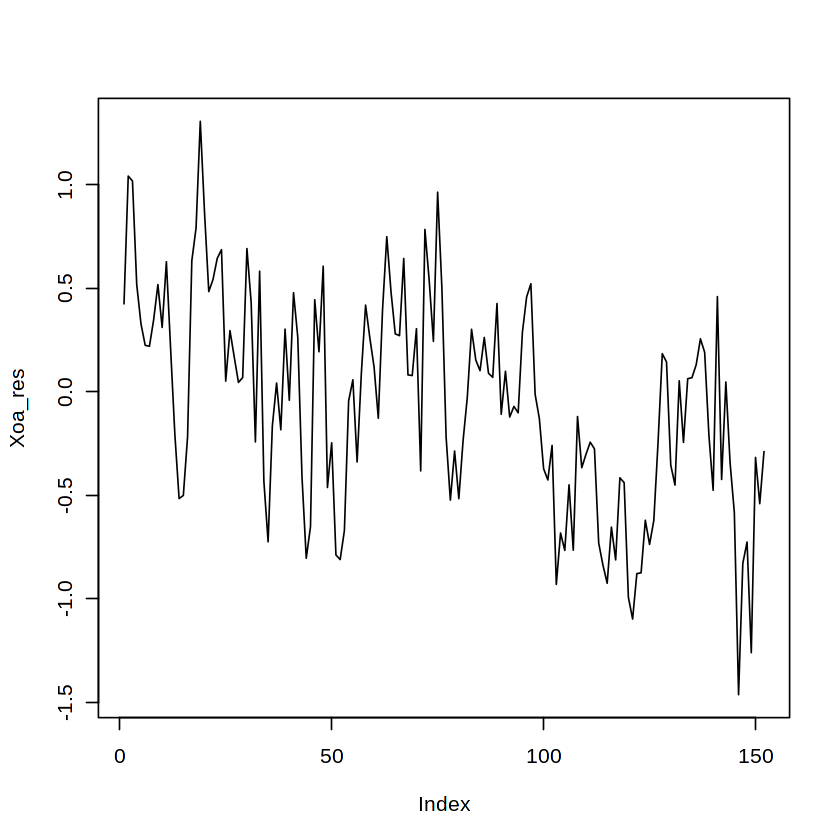

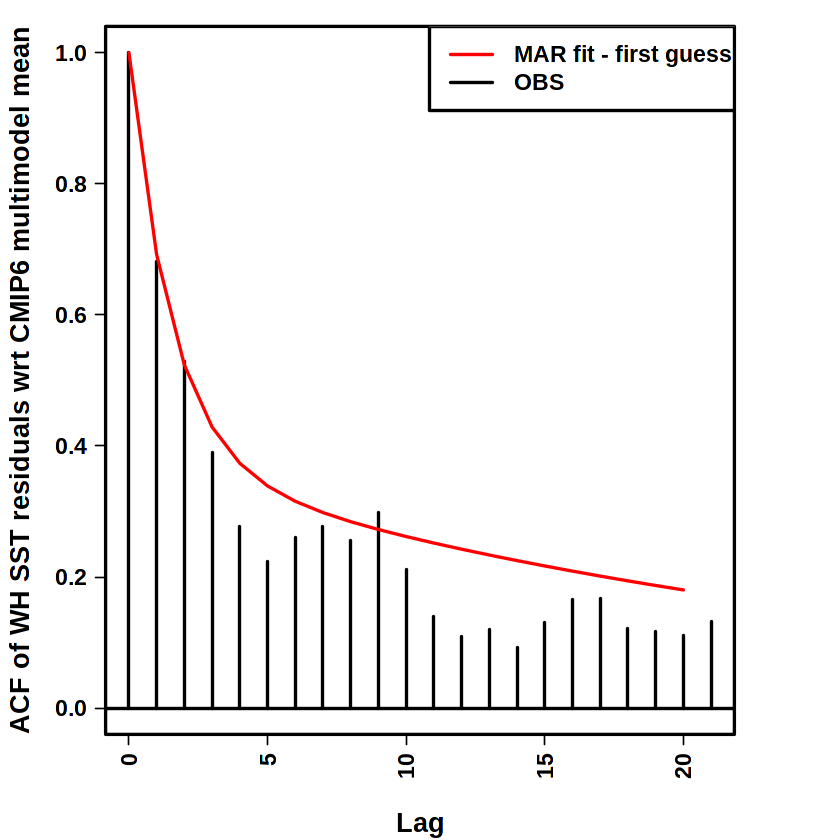

In [17]:
res_glo_loc = list(Xog_res, Xoa_res)
theta_obs_glo_loc = estim_mar_dep(theta_obs_glo,theta_obs_loc,res_glo_loc)
Sigma_obs = Sigma_mar_dep(theta_obs_glo_loc,res_glo_loc)

plot(Xoa_res,type="l")

# Check that MAR modelling is ok
acf_res = acf(Xoa_res, plot=F)
par(cex=1.1,font=2, font.lab=2,font.axis=2,lwd=2,mgp=c(2.8,.7,0),mar=c(4,4,1,4),las=2,tcl=-.4,cex.lab=1.2)
plot(acf_res,ylab="ACF of WH SST residuals wrt CMIP6 multimodel mean",ci=0,lwd=2,ylim=c(0,1))
colors_acf = c("red", "black")
lines(0:20, Sigma_obs_iv_loc[1,1:21]/Sigma_obs_iv_loc[1,1], col=colors_acf[1], lwd=2)
legend("topright", legend = c("MAR fit - first guess", "OBS"), col = colors_acf, lwd=2, lty=1)

The WH SST residuals show a clear artifical trend due to the misuse of the raw CMIP6 multi-model mean to estimate the forced response. Thus, I apply the iterative algorithm to get an estimate of WH SST internal variability consistent with observations.

First I apply the constraint with this first flawed estimate.

#### d. Prepare **model** data
By concatenating the appropriate arrays

In [18]:
year_ghg = 1850:2020
Xm = abind(Xg_fit[,,"all",Models],#
           Xg_fit[,,"nat",Models],#
           Xg_fit[as.character(year_ghg),,"ghg",Models],#
           Xa_fit[,,"all",Models],#
           Xa_fit[,,"nat",Models],#
           Xa_fit[as.character(year_ghg),,"ghg",Models],#
           along=1, use.dnns=T)
dimnames(Xm)$year = c(paste0(year_g,"_glo_all"),#
                     paste0(year_g,"_glo_nat"),
                     paste0(year_ghg,"_glo_ghg"),
                     paste0(year_a,"_loc_all"),
                     paste0(year_a,"_loc_nat"),
                     paste0(year_ghg,"_loc_ghg")#,
                     )

#### e. Define the prior

In [19]:
# For the three SSP scenarios

prior_mean_26 = apply(Xm[,"histssp126",],1,mean)
prior_var_26 = var(t(Xm[,"histssp126",]))

prior_mean_45 = apply(Xm[,"histssp245",],1,mean)
prior_var_45 = var(t(Xm[,"histssp245",]))

prior_mean_85 = apply(Xm[,"histssp585",],1,mean)
prior_var_85 = var(t(Xm[,"histssp585",]))

#### f. Apply the KCC constrain by (glo+reg) observations

In [20]:
source("./routines/constrain.R") # Required for obs with best-estimate only. 
CX_full_26 = constrain_array(prior_mean_26,prior_var_26,Xo_full,Sigma_obs,Nres=Nres)
CX_full_45 = constrain_array(prior_mean_45,prior_var_45,Xo_full,Sigma_obs,Nres=Nres)
CX_full_85 = constrain_array(prior_mean_85,prior_var_85,Xo_full,Sigma_obs,Nres=Nres)

#### f. Apply the iterative algorithm constrain to get consistent estimate of internal variability

I used the CX_full_45 array to re-estimate the residuals from Xoa and Xog, following Qasmi and Ribes (Sc Adv).

In [21]:
# recompute sigma obs -- iter 1

Xg_mmm  = CX_full_45[,"be","glo","all","cons"] #apply(Xg_fit[,"all",],1,mean,na.rm=T)
Xgc_mmm = Xg_mmm - mean(Xg_mmm[year_g %in% ref_obs])
Xog_res1 = Xogc - Xgc_mmm[as.character(year_og)]
# Regional T: Xa
Xa_mmm  = CX_full_45[,"be","loc","all","cons"] #apply(Xa_fit[,"all",],1,mean,na.rm=T)
Xac_mmm = Xa_mmm - mean(Xa_mmm[year_a %in% ref_obs])
Xoa_res1 = Xoac - Xac_mmm[as.character(year_oa)]


# Fit the parameters of the MAR models on residuals
message("Fitting MAR parameters (may take some time!)...")
theta1_obs_glo = estim_mar2_link(Xog_res1)
# Compute the associated covariance matrix
Sigma1_obs_iv_glo = Sigma_mar2(theta1_obs_glo,Xog_res)
# Add the measurement uncertainty contribution
Sigma1_obs_glo = Sigma1_obs_iv_glo + var(t(Xog[as.character(year_og),-201]))


theta1_obs_loc = estim_mar2_link(Xoa_res1)
# Compute the associated covariance matrix
Sigma1_obs_iv_loc = Sigma_mar2(theta1_obs_loc,Xoa_res)
# Add the measurement uncertainty contribution
Sigma1_obs_loc = Sigma1_obs_iv_loc + var(t(Xoa[as.character(year_oa),-201]))


Fitting MAR parameters (may take some time!)...



initial  value -625.928055 
iter   2 value -633.685014
iter   3 value -634.540364
iter   4 value -634.760185
iter   5 value -635.536980
iter   6 value -636.123338
iter   7 value -636.349206
iter   8 value -636.487776
iter   9 value -636.541656
iter  10 value -636.544184
iter  10 value -636.544192
final  value -636.544192 
converged
initial  value -155.520479 
iter   2 value -155.648128
iter   3 value -155.803099
iter   4 value -155.846803
iter   5 value -155.961318
iter   6 value -155.963596
iter   7 value -155.965708
iter   8 value -155.966576
iter   9 value -155.971101
iter  10 value -155.972678
iter  11 value -155.977300
iter  12 value -155.978247
iter  13 value -155.982251
iter  14 value -155.989034
iter  15 value -155.995852
iter  16 value -155.995867
iter  17 value -156.010897
iter  18 value -156.027891
iter  19 value -156.039533
iter  20 value -156.042321
iter  21 value -156.045303
iter  22 value -156.079047
iter  23 value -156.147647
iter  24 value -156.239712
iter  25 value -1

We check that the artifical trend is less affecting the residuals.

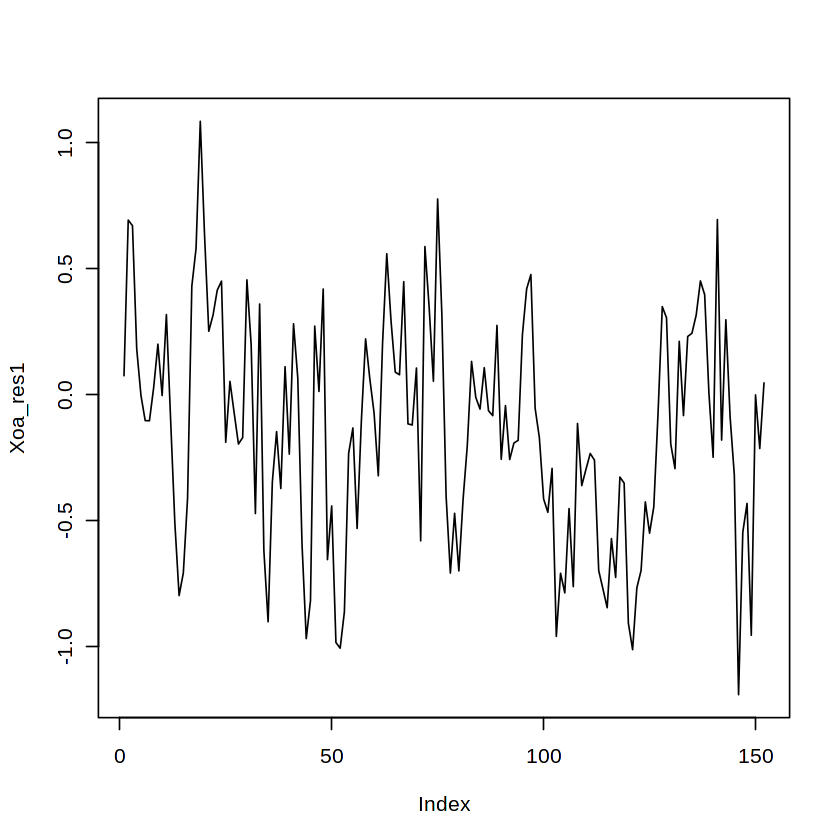

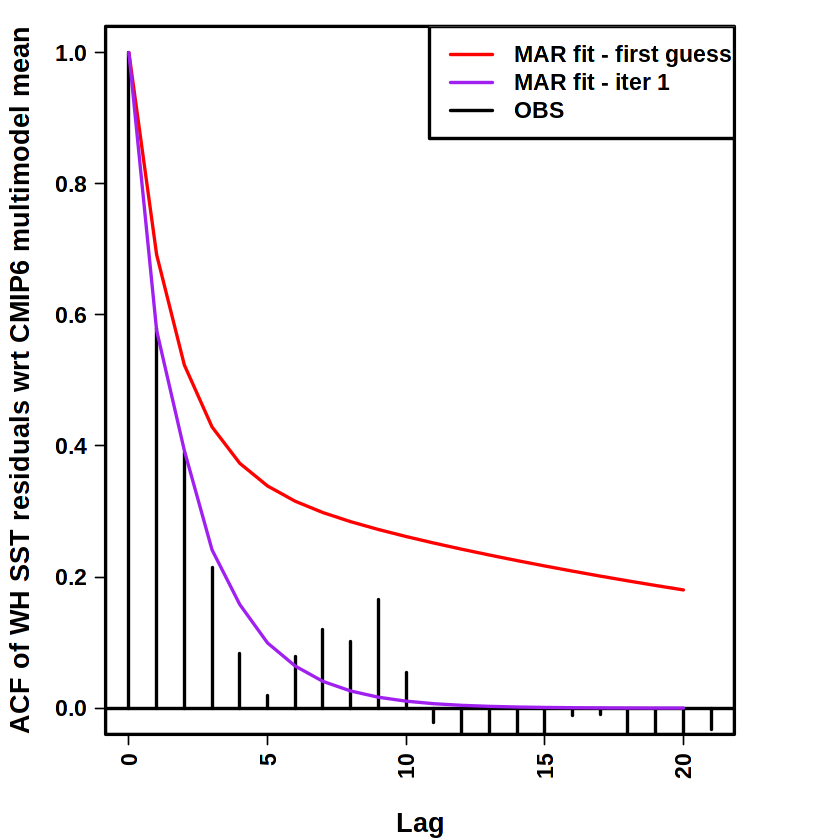

In [22]:
res1_glo_loc = list(Xog_res1, Xoa_res1)
theta1_obs_glo_loc = estim_mar_dep(theta1_obs_glo,theta1_obs_loc,res1_glo_loc)
Sigma1_obs = Sigma_mar_dep(theta1_obs_glo_loc,res1_glo_loc)

plot(Xoa_res1,type="l")
acf_res = acf(Xoa_res1, plot=F)
par(cex=1.1,font=2, font.lab=2,font.axis=2,lwd=2,mgp=c(2.8,.7,0),mar=c(4,4,1,4),las=2,tcl=-.4,cex.lab=1.2)
plot(acf_res,ylab="ACF of WH SST residuals wrt CMIP6 multimodel mean",ci=0,lwd=2,ylim=c(0,1))
colors_acf = c("red", "purple", "black")
lines(0:20, Sigma_obs_iv_loc[1,1:21]/Sigma_obs_iv_loc[1,1], col=colors_acf[1], lwd=2)
lines(0:20, Sigma1_obs_iv_loc[1,1:21]/Sigma1_obs_iv_loc[1,1], col=colors_acf[2], lwd=2)

legend("topright", legend = c("MAR fit - first guess", "MAR fit - iter 1", "OBS"), col = colors_acf, lwd=2, lty=1)

That is better, but there is still a trend, an other iteration is therefore necessary.

Consequently, I apply the constraint with this new estimate of internal variability.

In [23]:
Xm1_26 = abind(CX_full_26[,-1,"glo","all","cons"],#
           CX_full_26[,-1,"glo","nat","cons"],#
           CX_full_26[as.character(year_ghg),-1,"glo","ghg","cons"],#
           CX_full_26[,-1,"loc","all","cons"],#
           CX_full_26[,-1,"loc","nat","cons"],#
           CX_full_26[as.character(year_ghg),-1,"loc","ghg","cons"],#
           along=1, use.dnns=T)

Xm1_45 = abind(CX_full_45[,-1,"glo","all","cons"],#
           CX_full_45[,-1,"glo","nat","cons"],#
           CX_full_45[as.character(year_ghg),-1,"glo","ghg","cons"],#
           CX_full_45[,-1,"loc","all","cons"],#
           CX_full_45[,-1,"loc","nat","cons"],#
           CX_full_45[as.character(year_ghg),-1,"loc","ghg","cons"],#
           along=1, use.dnns=T)

Xm1_85 = abind(CX_full_85[,-1,"glo","all","cons"],#
           CX_full_85[,-1,"glo","nat","cons"],#
           CX_full_85[as.character(year_ghg),-1,"glo","ghg","cons"],#
           CX_full_85[,-1,"loc","all","cons"],#
           CX_full_85[,-1,"loc","nat","cons"],#
           CX_full_85[as.character(year_ghg),-1,"loc","ghg","cons"],#
           along=1, use.dnns=T)

dimnames(Xm1_26)$year = c(paste0(year_g,"_glo_all"),#
                     paste0(year_a,"_glo_nat"),
                     paste0(year_ghg,"_glo_ghg"),
                     paste0(year_a,"_loc_all"),
                     paste0(year_a,"_loc_nat"),
                     paste0(year_ghg,"_loc_ghg")#,
                      )

dimnames(Xm1_45)$year = dimnames(Xm1_26)$year
dimnames(Xm1_85)$year = dimnames(Xm1_26)$year

prior1_mean_26 = apply(Xm1_26,1,mean)
prior1_var_26= var(t(Xm1_26))

prior1_mean_45 = apply(Xm1_45,1,mean)
prior1_var_45= var(t(Xm1_45))

prior1_mean_85 = apply(Xm1_85,1,mean)
prior1_var_85= var(t(Xm1_85))

CX1_full_26 = constrain_array(prior1_mean_26,prior1_var_26,Xo_full,Sigma1_obs,Nres=Nres)
CX1_full_45 = constrain_array(prior1_mean_45,prior1_var_45,Xo_full,Sigma1_obs,Nres=Nres)
CX1_full_85 = constrain_array(prior1_mean_85,prior1_var_85,Xo_full,Sigma1_obs,Nres=Nres)

I re-estimate internal variability (iteration 2).

In [24]:
# recompute sigma obs -- iter 2

Xg_mmm  = CX1_full_45[,"be","glo","all","cons"] #apply(Xg_fit[,"all",],1,mean,na.rm=T)
Xgc_mmm = Xg_mmm - mean(Xg_mmm[year_g %in% ref_obs])
Xog_res2 = Xogc - Xgc_mmm[as.character(year_og)]
# Regional T: Xa
Xa_mmm  = CX1_full_45[,"be","loc","all","cons"] #apply(Xa_fit[,"all",],1,mean,na.rm=T)
Xac_mmm = Xa_mmm - mean(Xa_mmm[year_a %in% ref_obs])
Xoa_res2 = Xoac - Xac_mmm[as.character(year_oa)]


# Fit the parameters of the MAR models on residuals
message("Fitting MAR parameters (may take some time!)...")
theta2_obs_glo = estim_mar2_link(Xog_res2)
# Compute the associated covariance matrix
Sigma2_obs_iv_glo = Sigma_mar2(theta2_obs_glo,Xog_res)
# Add the measurement uncertainty contribution
Sigma2_obs_glo = Sigma2_obs_iv_glo + var(t(Xog[as.character(year_og),-201]))


theta2_obs_loc = estim_mar2_link(Xoa_res2)
# Compute the associated covariance matrix
Sigma2_obs_iv_loc = Sigma_mar2(theta2_obs_loc,Xoa_res)
# Add the measurement uncertainty contribution
Sigma2_obs_loc = Sigma2_obs_iv_loc + var(t(Xoa[as.character(year_oa),-201]))

Fitting MAR parameters (may take some time!)...



initial  value -625.656628 
iter   2 value -634.309029
iter   3 value -635.174027
iter   4 value -635.410272
iter   5 value -636.162250
iter   6 value -636.883847
iter   7 value -637.096740
iter   8 value -637.272223
iter   9 value -637.345568
iter  10 value -637.349835
iter  11 value -637.349861
iter  11 value -637.349870
iter  11 value -637.349873
final  value -637.349873 
converged
initial  value -157.319235 
iter   2 value -158.341958
iter   3 value -158.938691
iter   4 value -159.134544
iter   5 value -159.590260
iter   6 value -159.670550
iter   7 value -159.681247
iter   8 value -159.686379
iter   9 value -159.688098
iter  10 value -159.688370
iter  10 value -159.688372
final  value -159.688372 
converged


I check that the residuals do not show a trend.

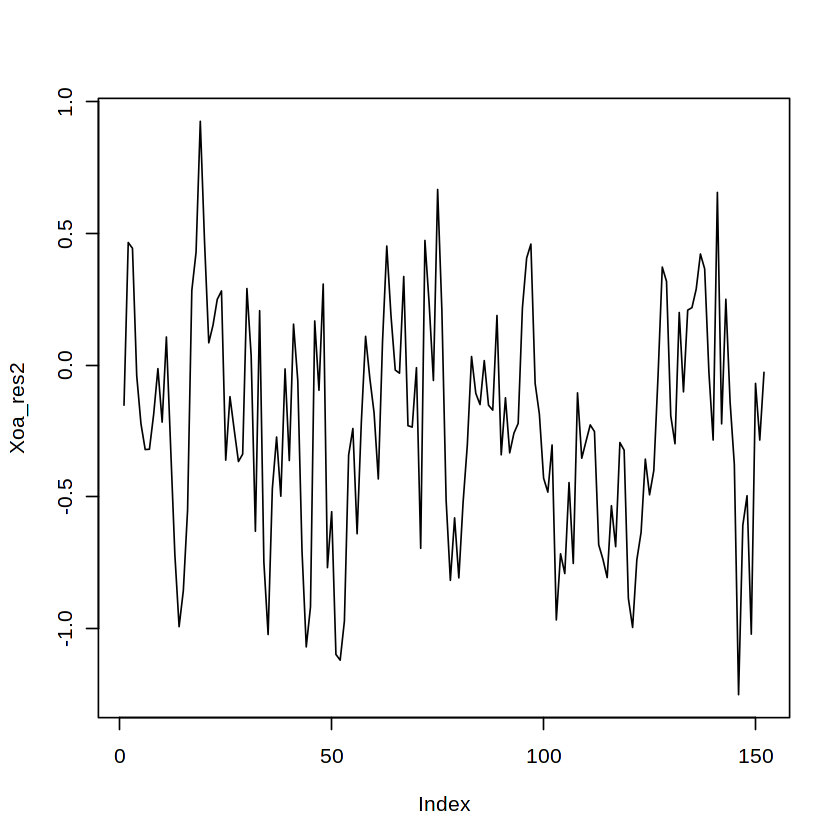

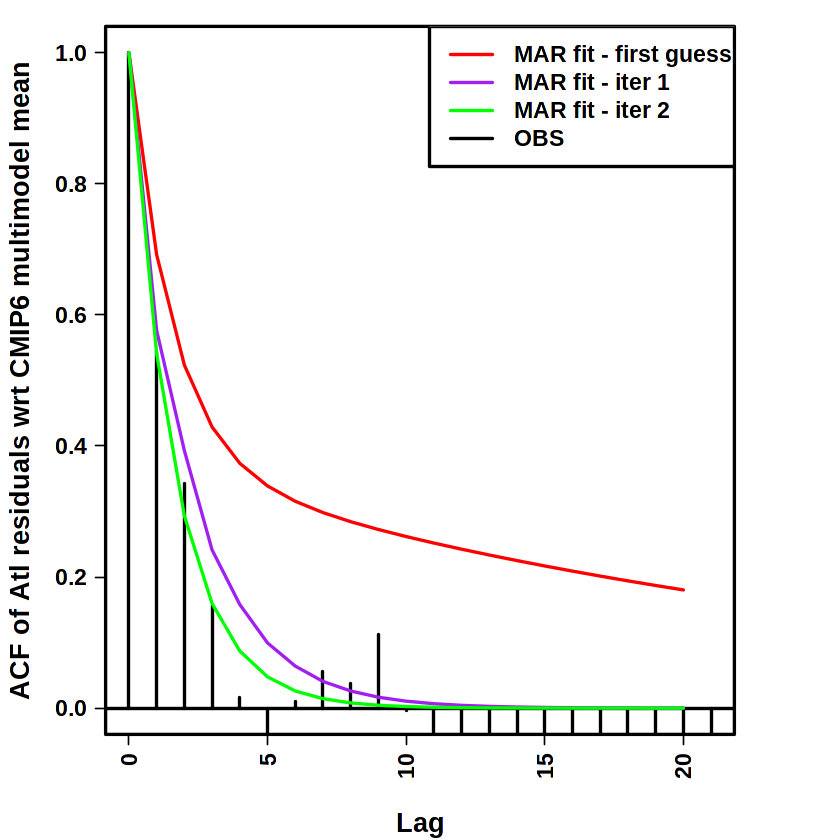

In [25]:

res2_glo_loc = list(Xog_res2, Xoa_res2)
theta2_obs_glo_loc = estim_mar_dep(theta2_obs_glo,theta2_obs_loc,res2_glo_loc)
Sigma2_obs = Sigma_mar_dep(theta2_obs_glo_loc,res2_glo_loc)

plot(Xoa_res2,type="l")

acf_res = acf(Xoa_res2, plot=F)
par(cex=1.1,font=2, font.lab=2,font.axis=2,lwd=2,mgp=c(2.8,.7,0),mar=c(4,4,1,4),las=2,tcl=-.4,cex.lab=1.2)
plot(acf_res,ylab="ACF of Atl residuals wrt CMIP6 multimodel mean",ci=0,lwd=2,ylim=c(0,1))
colors_acf = c("red", "purple", "green", "black")
lines(0:20, Sigma_obs_iv_loc[1,1:21]/Sigma_obs_iv_loc[1,1], col=colors_acf[1], lwd=2)
lines(0:20, Sigma1_obs_iv_loc[1,1:21]/Sigma1_obs_iv_loc[1,1], col=colors_acf[2], lwd=2)
lines(0:20, Sigma2_obs_iv_loc[1,1:21]/Sigma2_obs_iv_loc[1,1], col=colors_acf[3], lwd=2)

legend("topright", legend = c("MAR fit - first guess", "MAR fit - iter 1", "MAR fit - iter 2","OBS"), col = colors_acf, lwd=2, lty=1)


I verify that the algorithm has converged, by running a third iteration.

In [26]:
Xm2_26 = abind(CX1_full_26[,-1,"glo","all","cons"],#
           CX1_full_26[,-1,"glo","nat","cons"],#
           CX1_full_26[as.character(year_ghg),-1,"glo","ghg","cons"],#
           CX1_full_26[,-1,"loc","all","cons"],#
           CX1_full_26[,-1,"loc","nat","cons"],#
           CX1_full_26[as.character(year_ghg),-1,"loc","ghg","cons"],#
           along=1, use.dnns=T)

Xm2_45 = abind(CX1_full_45[,-1,"glo","all","cons"],#
           CX1_full_45[,-1,"glo","nat","cons"],#
           CX1_full_45[as.character(year_ghg),-1,"glo","ghg","cons"],#
           CX1_full_45[,-1,"loc","all","cons"],#
           CX1_full_45[,-1,"loc","nat","cons"],#
           CX1_full_45[as.character(year_ghg),-1,"loc","ghg","cons"],#
           along=1, use.dnns=T)

Xm2_85 = abind(CX1_full_85[,-1,"glo","all","cons"],#
           CX1_full_85[,-1,"glo","nat","cons"],#
           CX1_full_85[as.character(year_ghg),-1,"glo","ghg","cons"],#
           CX1_full_85[,-1,"loc","all","cons"],#
           CX1_full_85[,-1,"loc","nat","cons"],#
           CX1_full_85[as.character(year_ghg),-1,"loc","ghg","cons"],#
           along=1, use.dnns=T)

dimnames(Xm2_26)$year = c(paste0(year_g,"_glo_all"),#
                     paste0(year_a,"_glo_nat"),
                     paste0(year_ghg,"_glo_ghg"),
                     paste0(year_a,"_loc_all"),
                     paste0(year_a,"_loc_nat"),
                     paste0(year_ghg,"_loc_ghg")#,
                     #paste0(year_am,"_amoc_all"),
                     #paste0(year_am,"_amoc_nat")
                      )

dimnames(Xm2_45)$year = dimnames(Xm2_26)$year
dimnames(Xm2_85)$year = dimnames(Xm2_26)$year

prior2_mean_26 = apply(Xm2_26,1,mean)
prior2_var_26= var(t(Xm2_26))

prior2_mean_45 = apply(Xm2_45,1,mean)
prior2_var_45= var(t(Xm2_45))

prior2_mean_85 = apply(Xm2_85,1,mean)
prior2_var_85= var(t(Xm2_85))

CX2_full_26 = constrain_array(prior2_mean_26,prior2_var_26,Xo_full,Sigma2_obs,Nres=Nres)
CX2_full_45 = constrain_array(prior2_mean_45,prior2_var_45,Xo_full,Sigma2_obs,Nres=Nres)
CX2_full_85 = constrain_array(prior2_mean_85,prior2_var_85,Xo_full,Sigma2_obs,Nres=Nres)

In [27]:
# recompute sigma obs -- iter 3

Xg_mmm  = CX2_full_45[,"be","glo","all","cons"] #apply(Xg_fit[,"all",],1,mean,na.rm=T)
Xgc_mmm = Xg_mmm - mean(Xg_mmm[year_g %in% ref_obs])
Xog_res3 = Xogc - Xgc_mmm[as.character(year_og)]
# Regional T: Xa
Xa_mmm  = CX2_full_45[,"be","loc","all","cons"] #apply(Xa_fit[,"all",],1,mean,na.rm=T)
Xac_mmm = Xa_mmm - mean(Xa_mmm[year_a %in% ref_obs])
Xoa_res3 = Xoac - Xac_mmm[as.character(year_oa)]


# Fit the parameters of the MAR models on residuals
message("Fitting MAR parameters (may take some time!)...")
theta3_obs_glo = estim_mar2_link(Xog_res3)
# Compute the associated covariance matrix
Sigma3_obs_iv_glo = Sigma_mar2(theta3_obs_glo,Xog_res)
# Add the measurement uncertainty contribution
Sigma3_obs_glo = Sigma2_obs_iv_glo + var(t(Xog[as.character(year_og),-201]))


theta3_obs_loc = estim_mar2_link(Xoa_res3)
# Compute the associated covariance matrix
Sigma3_obs_iv_loc = Sigma_mar2(theta3_obs_loc,Xoa_res)
# Add the measurement uncertainty contribution
Sigma3_obs_loc = Sigma3_obs_iv_loc + var(t(Xoa[as.character(year_oa),-201]))


Fitting MAR parameters (may take some time!)...



initial  value -625.519497 
iter   2 value -634.557271
iter   3 value -635.429412
iter   4 value -635.671183
iter   5 value -636.424295
iter   6 value -637.217561
iter   7 value -637.429091
iter   8 value -637.616962
iter   9 value -637.700614
iter  10 value -637.705947
iter  11 value -637.705979
iter  11 value -637.705988
iter  11 value -637.705992
final  value -637.705992 
converged
initial  value -157.749535 
iter   2 value -159.262990
iter   3 value -160.050860
iter   4 value -160.316331
iter   5 value -160.878827
iter   6 value -161.030052
iter   7 value -161.075140
iter   8 value -161.082199
iter   9 value -161.086062
iter  10 value -161.087684
iter  11 value -161.087690
iter  12 value -161.087736
iter  13 value -161.087897
iter  14 value -161.087913
iter  14 value -161.087914
iter  14 value -161.087914
final  value -161.087914 
converged


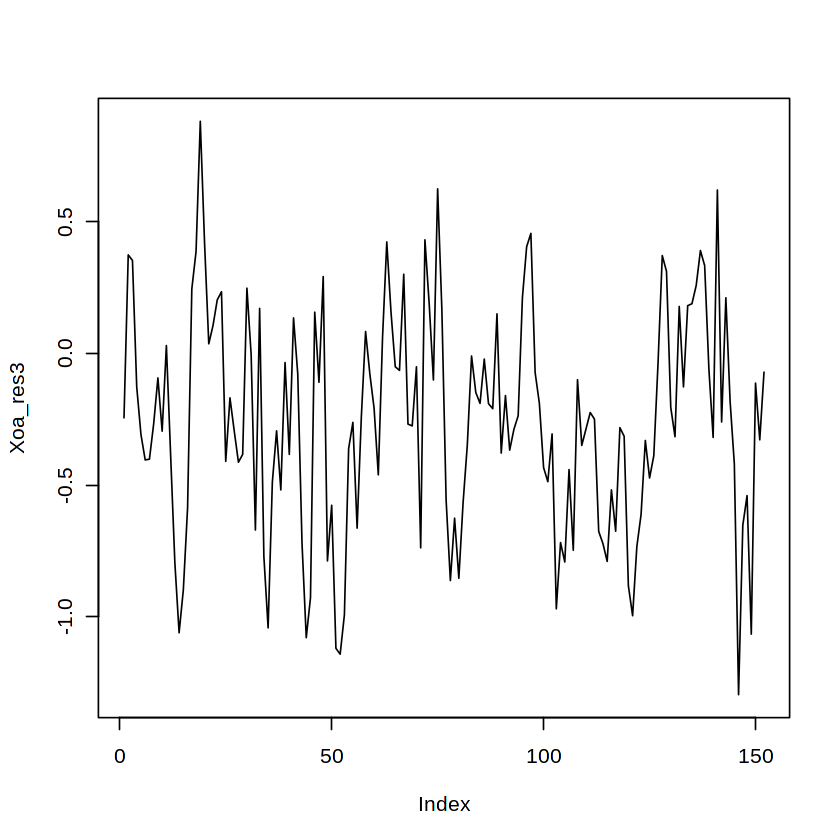

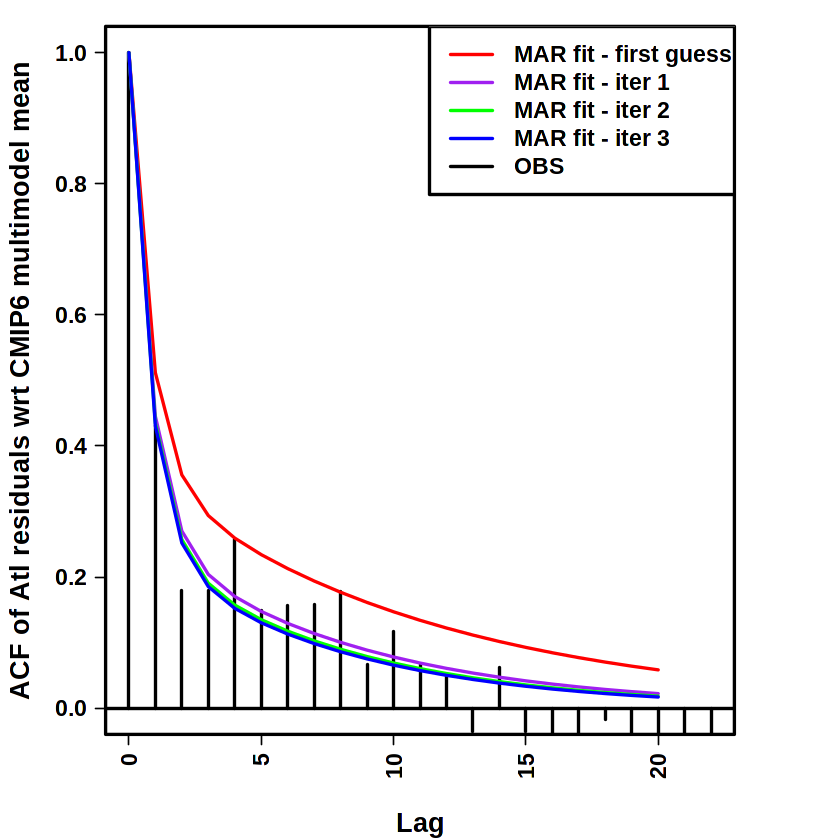

In [28]:
res3_glo_loc = list(Xog_res3, Xoa_res3)
theta3_obs_glo_loc = estim_mar_dep(theta3_obs_glo,theta3_obs_loc,res3_glo_loc)
Sigma3_obs = Sigma_mar_dep(theta3_obs_glo_loc,res3_glo_loc)

plot(Xoa_res3,type="l")

acf_res = acf(Xog_res3, plot=F)
par(cex=1.1,font=2, font.lab=2,font.axis=2,lwd=2,mgp=c(2.8,.7,0),mar=c(4,4,1,4),las=2,tcl=-.4,cex.lab=1.2)
plot(acf_res,ylab="ACF of Atl residuals wrt CMIP6 multimodel mean",ci=0,lwd=2,ylim=c(0,1))
colors_acf = c("red", "purple", "green", "blue", "black")
lines(0:20, Sigma_obs_iv_glo[1,1:21]/Sigma_obs_iv_glo[1,1], col=colors_acf[1], lwd=2)
lines(0:20, Sigma1_obs_iv_glo[1,1:21]/Sigma1_obs_iv_glo[1,1], col=colors_acf[2], lwd=2)
lines(0:20, Sigma2_obs_iv_glo[1,1:21]/Sigma2_obs_iv_glo[1,1], col=colors_acf[3], lwd=2)
lines(0:20, Sigma3_obs_iv_glo[1,1:21]/Sigma3_obs_iv_glo[1,1], col=colors_acf[4], lwd=2)

legend("topright", legend = c("MAR fit - first guess", "MAR fit - iter 1", "MAR fit - iter 2", "MAR fit - iter 3", "OBS"), col = colors_acf, lwd=2, lty=1)


The MAR fits from the second and third iterations are almost identical, meaning that the algorithm has converged.

## 6. Generate plots

For each figure, I just source the corresponding code. 

**Figure 2**: Attribution

Loading required package: plotrix



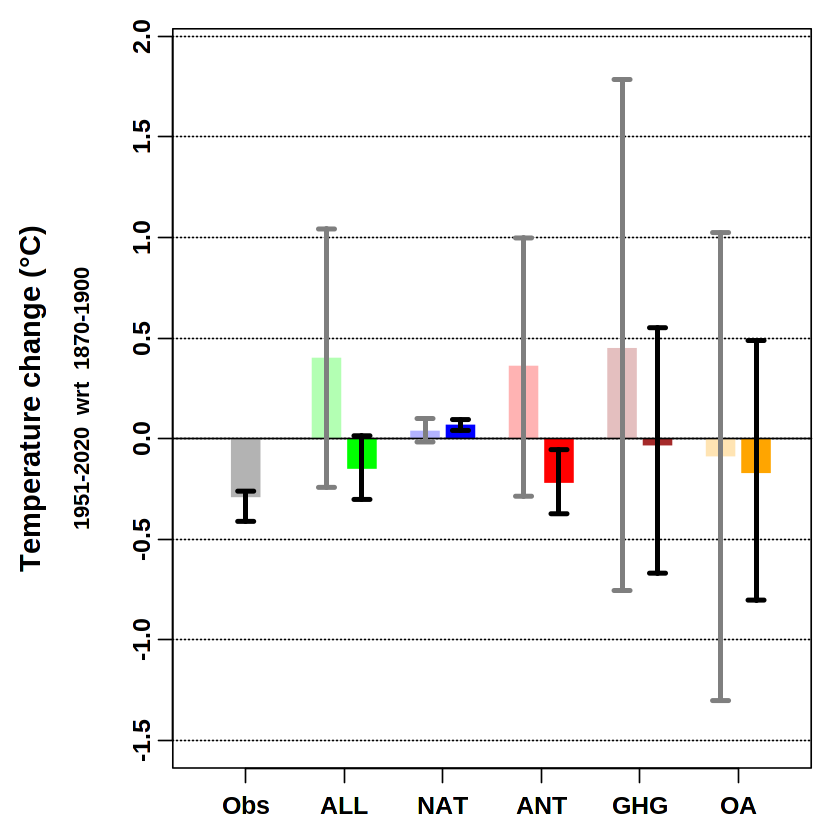

In [29]:
source("routines/plot_da_iter.R")
ylim_da = c(-1.5,1.9)
Qtable_damip = plot_da_iter(Xoa[as.character(year_oa),], CX_full_45[,,"loc",,],CX2_full_45[,,"loc",,],ref_period=1870:1900,pres_period=1951:2020,temporal="delta",method="quantile",ylim=ylim_da)


**Figure 3**: Projections

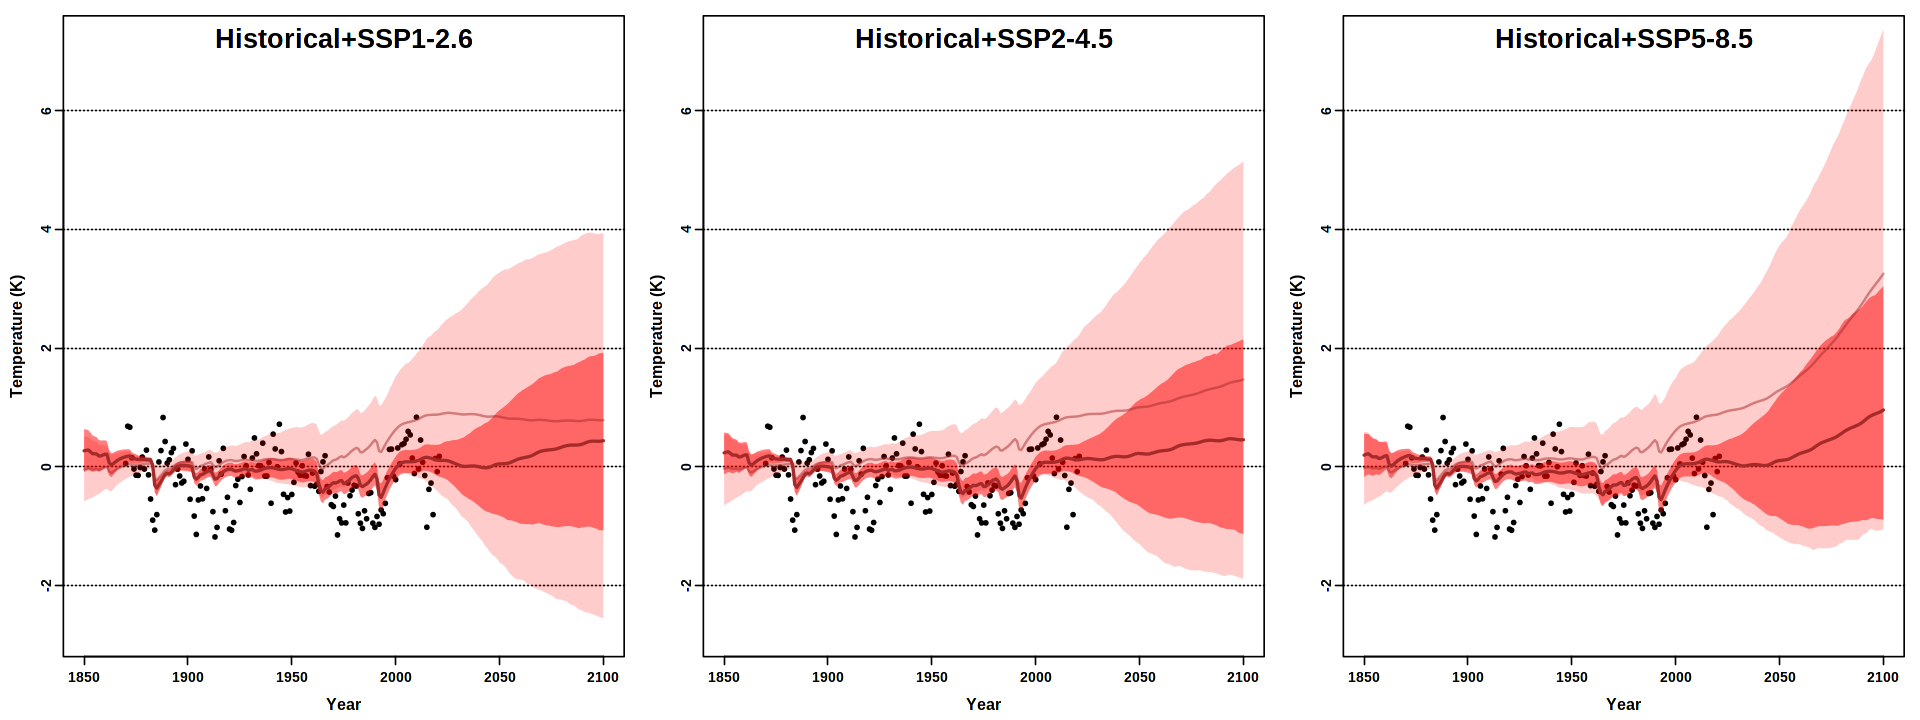

In [30]:
source("routines/plot_cons.R")
set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

ylim = c(-2.8,7.2)
ref_plot = 1870:1900

set_plot_dimensions(16, 6)

par(mfrow=c(1,3))
plot_cons_iter(CX2_full_26[,,"loc",,], CX_full_26[,,"loc",,], Xoa[as.character(year_oa),-201], ref_plot=ref_plot, ny=ny_a, ylim=ylim, title="Historical+SSP1-2.6")
plot_cons_iter(CX2_full_45[,,"loc",,], CX_full_45[,,"loc",,], Xoa[as.character(year_oa),-201], ref_plot=ref_plot, ny=ny_a, ylim=ylim, title="Historical+SSP2-4.5")
plot_cons_iter(CX2_full_85[,,"loc",,], CX_full_85[,,"loc",,], Xoa[as.character(year_oa),-201], ref_plot=ref_plot, ny=ny_a, ylim=ylim, title="Historical+SSP5-8.5")